### Module 15: More About Link Analysis

Consider an implementation of the Block-Stripe Algorithm discussed in Section 5.2 to compute PageRank on a graph of N nodes (i.e., Web pages). Suppose each page has, on average, 20 links, and we divide the new rank vector into k blocks (and correspondingly, the matrix M into k stripes). Each stripe of M has one line per "source" web page, in the format:

[source_id, degree, m, dest_1,...., dest_m]

Notice that we had to add an additional entry, m, to denote the number of destination nodes in this stripe, which of course is no more than the degree of the node. Assume that all entries (scores, degrees, identifiers,...) are encoded using 4 bytes.

There is an additional detail we need to account for, namely, locality of links. As a very simple model, assume that we divide web pages into two disjoint sets:
- Introvert pages, which link only to other pages within the same host as themselves.
- Extrovert pages, which have links to pages across several hosts.

Assume a fraction x of pages (0 <= x <= 1) are introverts, and the rest are extroverts. The blocks are arranged such that pages within a host are in the same block. For simplicity, assume that the links from the extrovert pages are spread uniformly across the k stripes (this is reasonably accurate for small values of k).

Construct a formula that counts the amount of I/O per PageRank iteration in terms of N, x, and k.

Note. There are some additional optimizations one can think of, such as striping the old score vector, encoding introvert and extrovert pages using different schemes, etc. For the purposes of working this problem, assume we don't do any optimizations beyond the block-stripe algorithm discussed in class.

In [22]:
kx_values = [(3, 0.75),
              (3,  0.5),
              (2, 0.75),
              (2,  0.5)]

# there are 1 billion web pages
N = 10**9

# each page has 20 links on average
m = 20

for k, x in kx_values:
    num_introvert = N * x
    num_extrovert = (1 - x) * N
    # introverts link only to other pages in the same block
    introvert_size = (3 + 20) * 4
    total_introvert_size = num_introvert * introvert_size
    # extroverts have links to pages spread uniformly across stripes
    extrovert_size = (3 + m/k) * 4 * k
    total_extrovert_size = num_extrovert * extrovert_size
    # the PageRank vector will be read k times and written once
    bytes_to_read_write_pagerank_vectors = 4 * (k + 1) * N
    total_bytes = sum([
        total_introvert_size,
        total_extrovert_size,
        bytes_to_read_write_pagerank_vectors,
    ])
    print('Amount of I/O per PageRank iteration for k = {}, x = {}: {}GB'.format(
        k,
        x,
        int(total_bytes/10**9),
    ))

Amount of I/O per PageRank iteration for k = 3, x = 0.75: 114GB
Amount of I/O per PageRank iteration for k = 3, x = 0.5: 120GB
Amount of I/O per PageRank iteration for k = 2, x = 0.75: 107GB
Amount of I/O per PageRank iteration for k = 2, x = 0.5: 110GB


Consider the link graph

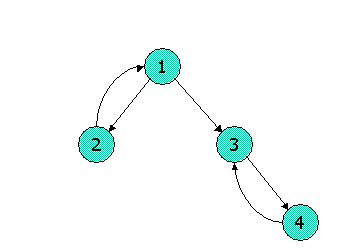

In [23]:
from IPython.display import Image
Image(filename='pagerank.png')

First, construct the L, the link matrix, as discussed in Section 5.5 on the HITS algorithm. Then do the following:
1. Start by assuming the hubbiness of each node is 1; that is, the vector h is (the transpose of) [1,1,1,1].
2. Compute an estimate of the authority vector a=L.Th.
3. Normalize a by dividing all values so the largest value is 1.
4. Compute an estimate of the hubbiness vector h=La.
5. Normalize h by dividing all values so the largest value is 1.
6. Repeat steps 2-5.

In [14]:
import numpy as np

L = np.array([[0, 1, 1, 0],
              [1, 0, 0, 0],
              [0, 0, 0, 1],
              [0, 0, 1, 0]])

h = np.array([1, 1, 1, 1]).T

for i in range(0, 2):
    a = L.T @ h
    a = a / max(a)
    h = L @ a
    h = h / max(h)

print('The authority vector a is ', a)
print('The hubbiness vector h is ', h)

The authority vector a is  [0.2 0.6 1.  0.2]
The hubbiness vector h is  [1.    0.125 0.125 0.625]


Here is an example of a tiny link matrix L, as discussed in Section 5.5 on the HITS algorithm.

In [16]:
L = np.array([[1, 1],
              [0, 1]])

The graph represented by L has two nodes. Let [x,y] be (the transpose of) the hubbiness vector for the two nodes, in the order given by L. Using the method in Section 5.5.2, set up a matrix-vector equation for [x,y], involving an unknown scale parameter λμ. Then, solve for λμ and the ratio of x to y, each to three decimal places.

In [46]:
import math

# h = lambda * mu * L * L.T * h
#
# L @ L.T = np.array([2, 1],
#                    [1, 1])
#
# Let f be the scaling factor, 1 / (lambda * mu)
# fx = 2x + y --- Equation １
# fy =  x + y --- Equation 2
#
# From Equation 2:
#  y = x / (f - 1) --- Equation 3
# Substituting y in terms of x into Equation 1:
#           fx = 2x + x / (f - 1)
#     f(f - 1) = 2(f - 1) + 1
# f^2 - 3f + 1 = 0
# f = 3/2 - sqrt(5) / 2 and 3/2 + sqrt(5) / 2
# Since f > 1, f = 3/2 + sqrt(5) / 2
f = 3/2 + math.sqrt(5) / 2
print('lambda * mu = {:.3}'.format(1/f))

# From Equation 3: y = x / (f - 1)
print('y = {:.3}x'.format(1 / (f - 1)))

lambda * mu = 0.382
y = 0.618x


The spam-farm architecture described in Section 5.4.1 suffers from the problem that the target page has many links --- one to each supporting page. To avoid that problem, the spammer could use the architecture shown below:

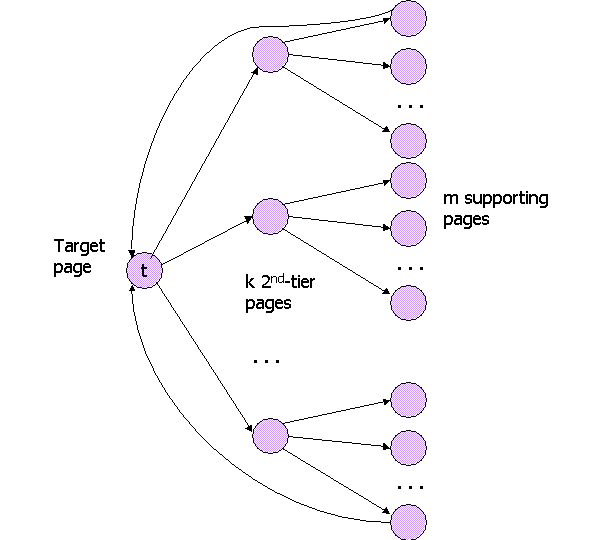

In [24]:
Image(filename='spamfarm.png')

There, k "second-tier" nodes act as intermediaries. The target page t has only to link to the k second-tier pages, and each of those pages links to m/k of the m supporting pages. Each of the supporting pages links only to t (although most of these links are not shown). Suppose the taxation parameter is β = 0.85, and x is the amount of PageRank supplied from outside to the target page. Let n be the total number of pages in the Web. Finally, let y be the PageRank of target page t. If we compute the formula for y in terms of k, m, and n, we get a formula with the form

y = ax + bm/n + ck/n

Note: To arrive at this form, it is necessary at the last step to drop a low-order term that is a fraction of 1/n. Determine coefficients a, b, and c, remembering that β is fixed at 0.85.

In [4]:
beta = 0.85

# The PageRank of t comes from 3 sources:
# 1. The contribution x from links outside the spam farm
# 2. beta * the PageRank of every supporting page that links to it
# 3. (1 - beta / n), t's share of the fraction of (1 - beta), which is negligible

# The PageRank of each 2nd-tier page is (beta)(y) / k + (1 - beta) / n
# The PageRank of each supporting page is 
# beta * the PageRank of the 2nd-tier page / 3 + (1 - beta) / n
# = (beta^2)(y) / (3k) + beta(1 - beta) / (3n)
# = (beta^2)(y) / (3k) - (beta^2 - beta) / (3n)
# = 

# Therefore the contribution to the PageRank of t
# from the supporting pages is (beta^3)(y)(m) / (3k)

# y = x + (beta^3)(y)(m) / (3k)


a = 1 / (1 - beta**3)
b = beta / (1 + beta + beta**2)
c = beta**2/ (1 + beta + beta**2)
print('a = {:.3}'.format(a))
print('b = {:.2}'.format(b))
print('c = {:.2}'.format(c))

a = 2.59
b = 0.33
c = 0.28
